In [152]:

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Objective: 
### &emsp;-Make a model that predicts the amount of wins a team will earn, based on their aggregated player statistics, 
### &emsp;-Apply the model to 2024 data to predict the outcome of the 2024 regular season.

In [154]:
class leagueStats:
    def __init__(self,df,features):
        self.df=df
        self.aggregates=self.features_dict(features)#dictionary that holds the columns as the key and the aggregate function
        #that should be applied as the value.
        self.features=features #The statistics for which we wish to calculate the difference between the league, division,mlb.


    def features_dict(self,F):
        """Returns a dictionary that is designed to be passed to the agg function, i.e {col_name:agg_func}."""
        D={}
        for i in F:
            D[i]='mean'
        return D

    def aggregatedStats(self,row,which='Division'):
        L=[]
        if which=='Division':
            df=self.df[(self.df['Year']==row['Year'])&(self.df['LEAGUE']==row['LEAGUE'])&(self.df['DIVISION']==row['DIVISION'])&
                       (self.df['CODE']!=row['CODE'])]
        elif which=='League':
            df = self.df[(self.df['Year'] == row['Year']) & (self.df['LEAGUE'] == row['LEAGUE'])&(self.df['CODE']!=row['CODE'])]
        else:
            df=self.df[(self.df['Year'] == row['Year']) &(self.df['CODE']!=row['CODE'])]
        for item in self.features:
            av=df[item].mean()
            L.append(row[item]-av)
        return pd.Series(L)
    def applyAgg(self):
        """Returns a dataFrame that includes columns for the teams stats relative to the teams league and division, as
        well as the entire mlb."""
        self.df[['DivDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats ,axis=1)
        self.df[['LeagueDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats,which='League',axis=1)
        self.df[['mlbDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats, which='MLB',axis=1)
        return self.df

#### Read in the TeamWins csv and add Features
**The csv contains the team statistics and wins. Apply the leagueStats method to add features that represent each teams statistics relative to averages for their league and division, as well as the entire mlb.**

In [156]:

data=pd.read_csv("TeamWins_UpdatedVersion.csv") #Data contains teams year stats with the amount of wins for each season
base_features=['AVG','OBP','SLG','HR','BB','BB_pitch','SO_pitch','WHIP_pitch','AVG_pitch','ERA_pitch','SB'] #These are the features for which
#to build the model.
data=leagueStats(data,base_features).applyAgg()  #Adds columns to the dataframe which are the differences between
#the teams statistics and those of their diviison/league.  Also adds columns for the differences between the team stats and
#the entire MLB.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             834 non-null    int64  
 1   TEAM                   834 non-null    object 
 2   LEAGUE                 834 non-null    object 
 3   G                      834 non-null    int64  
 4   AB                     834 non-null    int64  
 5   R                      834 non-null    int64  
 6   H                      834 non-null    int64  
 7   2B                     834 non-null    int64  
 8   3B                     834 non-null    int64  
 9   HR                     834 non-null    int64  
 10  RBI                    834 non-null    int64  
 11  BB                     834 non-null    int64  
 12  SO                     834 non-null    int64  
 13  SB                     834 non-null    int64  
 14  CS                     834 non-null    int64  
 15  AVG   

In [157]:
class playoffPicture:
    def __init__(self,df):
        self.df=df
        self.divisions=[]
        divisions = self.df['DIVISION'].unique()
        self.leagues = self.df['LEAGUE'].unique()
        for item in self.leagues:
            for elem in divisions:
                self.divisions.append((item, elem))
        self.division_winners=[]
        self.divWinFrames=self.divisionWinners()
        self.wildcards=self.getWildcard()
        

    def  Print(self):
        for item in self.divWinFrames:
            print(f"Division {item[0]} {item[1]}\n{item[2].to_markdown()}")
        print("\t\t\t\t\tWildcards")
        for item in self.wildcards:
            print(f"League {item[0]}\n\t{item[1].to_markdown()}")



    def divisionWinners(self):
        dataFrames=[]
        for item in self.divisions:
            df=self.df[(self.df['LEAGUE']==item[0])&(self.df['DIVISION']==item[1])]
            df=df.sort_values(by='Prediction',ascending=False)
            self.division_winners.append(df['CODE'].head().values[0])
            df=df[['CODE','Prediction']]
            df=df.rename(columns={'CODE':'Team','Prediction':'Wins'})
            dataFrames.append((item[0],item[1],df))
        return dataFrames
    def getWildcard(self):
        wildcards=[]
        for league in self.leagues:
            df=self.df[self.df['LEAGUE']==league]
            df=df.sort_values(by='Prediction',ascending=False)
            df=df[~df['CODE'].isin(self.division_winners)]
            df = df[['CODE', 'Prediction']]
            df = df.rename(columns={'CODE': 'Team', 'Prediction': 'Wins'})
            wildcards.append((league,df.head(3)))
        return wildcards
class randomForrests:
    def __init__(self,df,features):
        self.df=df
        """Add the difference metrics to the list of features.  These are metrics for the difference between the stats
        of the team and those of their division/league as well as the entire mlb."""
        self.features=features+['DivDiff_'+item for item in features]+['LeagueDiff_'+item for item in features]+['mlbDiff_'+item for item in features]
        self.regressor = RandomForestRegressor(n_estimators=250, random_state=0, min_samples_split=5)
        np.random.seed(458)
        self.train,self.test=tts(self.df, test_size=0.2)
        self.X_train=self.train[self.features]
        self.y_train=self.train['WINS']
        self.X_test=self.test[self.features]
        self.y_test=self.test['WINS']
        self.model=self.Model()


    def getParams(self):
        param_grid = {
            'n_estimators': [25, 50, 100, 150,200],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [3, 6, 9,12],
            'max_leaf_nodes': [3, 6, 9,12],
            'min_samples_split':[3,6,9,12]
        }

        grid_search = GridSearchCV(RandomForestRegressor(),
                                   param_grid=param_grid)
        grid_search.fit(self.X_train, self.y_train)
        print(grid_search.best_estimator_)
    def Model(self):
        """After tuning, I could not do better than the default parameters with 250 trees"""
        regressor = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200,max_depth=7))
        regressor.fit(self.X_train,self.y_train)
        return regressor
    def getError(self):
        """Returns the Root Mean Squared Error"""
        self.test['pred']=self.model.predict(self.X_test)
        return self.RMSE(self.test['WINS'],self.test['pred'])
    def RMSE(self,y,y_hat):
        return np.sqrt(sum((y-y_hat)**2)/len(y))
    def feature_selection(self):
        """Prints the most important features"""
        sel = SelectFromModel(RandomForestRegressor(n_estimators=200,max_depth=7, random_state=0, min_samples_split=6,max_leaf_nodes=14,min_samples_leaf=5))
        sel.fit(self.X_train, self.y_train)
        print(sel.get_support())
        selected_feat = self.X_train.columns[(sel.get_support())]
        print(selected_feat)
    def makePreds(self,df):
        """Returns a DataFrame with the predictions(amount of wins for each team).  The wins are adjusted to
        Account for the fact that there should be 2430 wins in a season."""
        X=df[self.features]
        df['Prediction']=self.model.predict(X)
        return self.CorrectWins(df)
    def CorrectWins(self,df):
        """Returns the amount of wins proportional to the total wins of all teams but in an amount that makes the total
        Amount of wins equal to the expected amount of wins for a season 2430."""
        predicted_total=df['Prediction'].sum()
        df['Prediction']=round((df['Prediction']/predicted_total)*(162*30/2))
        return df
def do_permutation_feature_importance(model,X_test,y_test):
    # Perform permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)
    
    # Create a dataframe of feature importances
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)
    
    # Print feature importances
    print("\nPermutation Feature Importance:")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.errorbar(feature_importance['feature'], feature_importance['importance'], 
                 yerr=feature_importance['std'], fmt='none', color='black')
    plt.title('Permutation Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return feature_importance


# Fit Random Forest Model

In [159]:
rf=randomForrests(data,base_features)
rf.getError()


4.935313578137891


Permutation Feature Importance:


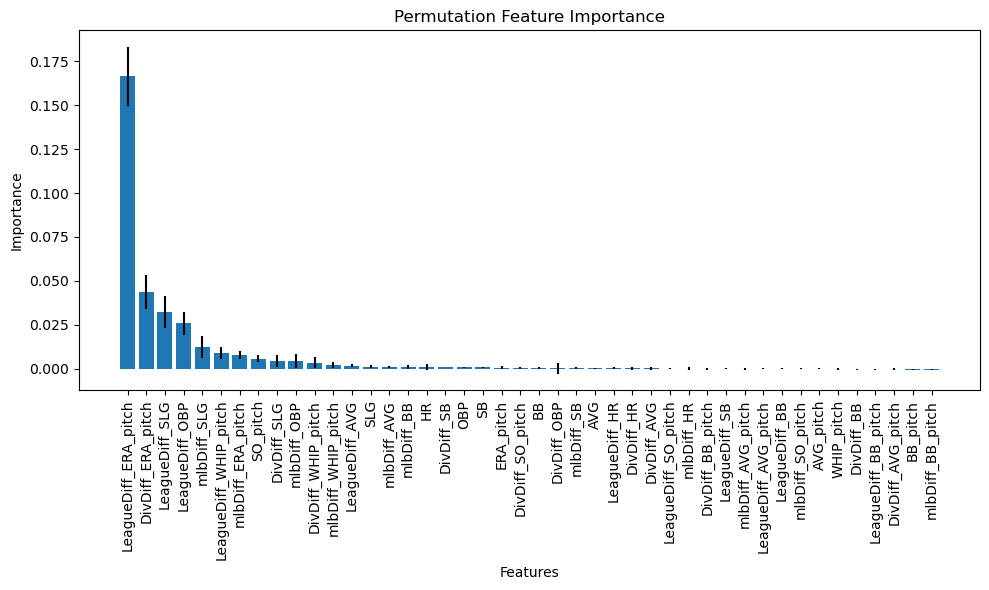

In [160]:
feature_importance=do_permutation_feature_importance(rf.model,rf.X_test,rf.y_test)

# Fit XgBoost Model

In [162]:
features=base_features+['DivDiff_'+item for item in base_features]+['LeagueDiff_'+item for item in base_features]+['mlbDiff_'+item for item in base_features]

In [163]:
rerun=False
if rerun:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [7,5,6],  # Added a high value to simulate "no max depth"
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.7,0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0,0.01]  # Consider adding more values if you want to explore this parameter
    }
    grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42),
                                       param_grid=param_grid,scoring='neg_mean_squared_error')
    CV=grid_search.fit(X_train,y_train)
    print(CV.best_params_)
else:
    D={'colsample_bytree': 0.8,
 'gamma': 0.01,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 300,
 'subsample': 0.7}
    print('**'*29, 'Best Parameters from first search ','**'*15)
    print(D)

********************************************************** Best Parameters from first search  ******************************
{'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.7}


In [167]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
train,test=tts(data,test_size=0.3)
X_train=train[features]
y_train=train['WINS']
X_test=test[features]
y_test=test['WINS']
model=xgb.XGBRegressor(random_state=42, n_estimators= 300,
    max_depth= 6,  # Added a high value to simulate "no max depth"
    learning_rate= 0.05,
    subsample=0.7,
    colsample_bytree= 0.7,
    gamma= 0.01,
    )
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('R2: ',r2_score(y_test,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test,y_pred)))


      

R2:  0.8191111399775199
RMSE:  4.97209495971379


### Since 300 was the maximum n_estimators parameter I tried higher numbers.

In [169]:
if rerun:
    param_grid2 = {
        'n_estimators': [300,350,400],
        'max_depth': [6],  # Added a high value to simulate "no max depth"
        'learning_rate': [0.05, 0.01],
        'subsample': [0.7,0.6],
        'colsample_bytree': [0.7,0.8],
        'gamma': [0.01,0.015]  # Consider adding more values if you want to explore this parameter
    }
    grid_search2 = GridSearchCV(xgb.XGBRegressor(random_state=42),
                                       param_grid=param_grid2,scoring='neg_mean_squared_error')
    CV2=grid_search2.fit(X_train,y_train)
    print(CV2.best_params_)
else:
    print('**'*29, 'Best Parameters from Second search ','**'*14)
    D={'colsample_bytree': 0.8,
 'gamma': 0.01,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 400,
 'subsample': 0.7}
    for key, value in D.items():
        print(f'{key}: {value}')

********************************************************** Best Parameters from Second search  ****************************
colsample_bytree: 0.8
gamma: 0.01
learning_rate: 0.05
max_depth: 6
n_estimators: 400
subsample: 0.7


In [173]:
model=xgb.XGBRegressor(random_state=42, n_estimators= 400,
    max_depth= 6,  # Added a high value to simulate "no max depth"
    learning_rate= 0.05,
    subsample=0.7,
    colsample_bytree= 0.7,
    gamma= 0.01)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test,y_pred)))


      

R2 0.8186952297931893
RMSE 4.977807742719685


#### The model with 300 trees performs slightly better.

# Permutation Feature Importance

R2 0.8191111399775199
RMSE 4.97209495971379

Permutation Feature Importance:


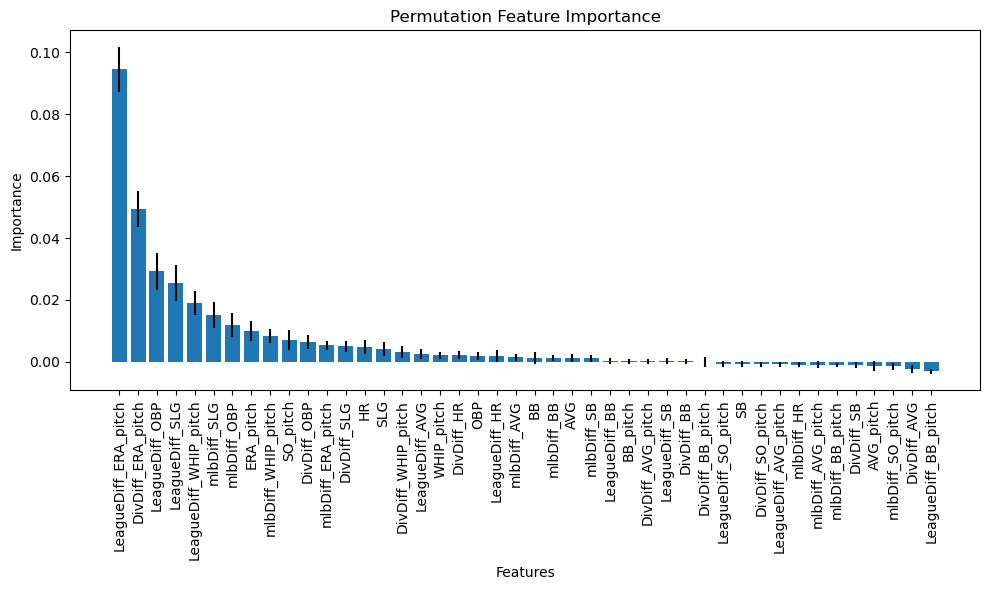

In [175]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
model=xgb.XGBRegressor(random_state=42, n_estimators= 300,
    max_depth= 6,  # Added a high value to simulate "no max depth"
    learning_rate= 0.05,
    subsample=0.7,
    colsample_bytree= 0.7,
    gamma= 0.01)
# Assuming you've already split your data and trained your model as in your original code

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print R2 and RMSE
print('R2', r2_score(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))

feature_importance=do_permutation_feature_importance(model,X_test,y_test)


**Remove Features that are negatively impacting the model performance**

In [179]:
keep_features=feature_importance[feature_importance['importance']>0]['feature'].values
X_train=train[keep_features]
y_train=train['WINS']
X_test=test[keep_features]
y_test=test['WINS']
model=xgb.XGBRegressor(random_state=42, n_estimators= 300,
    max_depth= 6,  # Added a high value to simulate "no max depth"
    learning_rate= 0.05,
    subsample=0.7,
    colsample_bytree= 0.7,
    gamma= 0.01)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test,y_pred)))

R2 0.8225944383198548
RMSE 4.923989509161874


In [181]:
import joblib
joblib.dump(model, 'best_model_xg.joblib')
np.save('best_model_xg_features.npy',keep_features)


# Predicting the 2024 Season

In [183]:
df_2024=pd.read_csv('2024teamStatsProjections2.csv')
df_2024=leagueStats(df_2024,base_features).applyAgg() 


In [185]:
def CorrectWins(df):
    """Returns the amount of wins proportional to the total wins of all teams but in an amount that makes the total
    Amount of wins equal to the expected amount of wins for a season 2430."""
    predicted_total=df['Predicted_Wins'].sum()
    df['Adjusted_Prediction']=round((df['Predicted_Wins']/predicted_total)*(162*30/2))
    return df
df_2024['Predicted_Wins']=model.predict(df_2024[keep_features])
df_2024=CorrectWins(df_2024)
df_2024['Prediction']=df_2024['Adjusted_Prediction']
playoffPicture(df_2024).Print()

Division NL W
|    | Team   |   Wins |
|---:|:-------|-------:|
| 13 | LAD    |     85 |
| 24 | SFG    |     82 |
| 22 | SDP    |     81 |
|  0 | ARI    |     79 |
|  8 | COL    |     64 |
Division NL E
|    | Team   |   Wins |
|---:|:-------|-------:|
|  1 | ATL    |     98 |
| 20 | PHI    |     89 |
| 18 | NYM    |     82 |
| 29 | WSN    |     72 |
| 14 | MIA    |     67 |
Division NL C
|    | Team   |   Wins |
|---:|:-------|-------:|
|  5 | CHC    |     90 |
|  6 | CIN    |     86 |
| 21 | PIT    |     81 |
| 25 | STL    |     80 |
| 15 | MIL    |     77 |
Division AL W
|    | Team   |   Wins |
|---:|:-------|-------:|
| 10 | HOU    |     86 |
| 12 | LAA    |     81 |
| 23 | SEA    |     81 |
| 27 | TEX    |     80 |
| 19 | OAK    |     69 |
Division AL E
|    | Team   |   Wins |
|---:|:-------|-------:|
| 17 | NYY    |     91 |
| 28 | TOR    |     91 |
|  3 | BOS    |     84 |
|  2 | BAL    |     83 |
| 26 | TBR    |     81 |
Division AL C
|    | Team   |   Wins |
|---:|:-------|-